In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
np.set_printoptions(suppress=True)
import pickle
import sys, os
import time
import libcamodocal
import matplotlib.pyplot as plt
import cv2
import quaternion
from IPython import display
from IPython.display import clear_output
import calib_utils

In [3]:
# define cb pattern
cb_pattern = (5,6)

#define checkerboard pattern size [m]
cb_size = .07

# load calib data
#calib_data = pickle.load(open("./../data/calibdata_22_03_2022_21_19_53_pick.pkl", "rb" ))
calib_data = pickle.load( open("/home/ralfi/Desktop/calibdata_29_03_2022_19_39_11.pkl", "rb" ))

# Setup Camera intrinsics
K = calib_data['intr']
print(K)

#Setup HEC Solver
#setup = calib.calibrator.Setup(2)
#cgi_cal = calib.calibrator.HandEyeCalibrator(setup)

[[644.39996338   0.         639.5       ]
 [  0.         644.39996338 359.5       ]
 [  0.           0.           1.        ]]


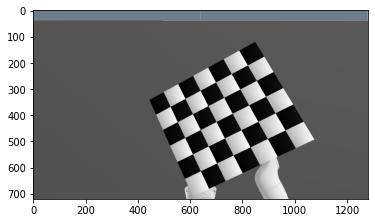

In [4]:
plt.imshow(calib_data['rgb'][0])

In [5]:
# generate pattern_3d
pattern_3d = np.zeros((np.prod(cb_pattern), 3), np.float32)
pattern_3d[:, :2] = np.indices(cb_pattern).T.reshape(-1, 2)
pattern_3d *= cb_size
pattern_3d = np.transpose(pattern_3d)

In [6]:


def draw(img, corners, K, rvecs, tvecs, points_2d):
    
    _, rVec, tVec = cv2.solvePnP(np.transpose(pattern_3d), points_2d, K, np.zeros((5,1)))
    axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)
    
    imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, K, np.zeros((5,1)))
    
    corner = tuple(corners[0].ravel())
    img = cv2.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5)
    
    
    img = cv2.drawChessboardCorners(rgb, cb_pattern, points_2d, ret)
    plt.figure(figsize=(20, 20), dpi=80)
    plt.imshow(img)
    
    return img


def draw2(rgb, cb_pattern, points_2d, ret=True):
    
    img = cv2.drawChessboardCorners(rgb, cb_pattern, points_2d, ret)
    plt.figure(figsize=(20, 20), dpi=80)
    plt.imshow(img)
    
    return img

def create_transform(R=np.eye(3),t=np.zeros((3))):
    transform = np.array([[R[0,0], R[0,1], R[0,2], t[0]],
                     [R[1,0], R[1,1], R[1,2], t[1]],
                      [R[2,0], R[2,1], R[2,2], t[2]],
                       [0,0,0,1]])

    #return transform
    return transform

def homTF2pose7d(homTF):
    
    pose7d = np.zeros(7)
    pose7d[0:3] = np.transpose(homTF[0:3, 3])

    R = homTF[0:3, 0:3]
    q_ = quaternion.from_rotation_matrix(R)
    q = quaternion.as_float_array(q_)

    pose7d[3:7] = q
    return pose7d

def review_img(i, rgb):
    
    print(f"Run {i}:")
    display.Image(rgb)
    plt.figure()

    plt.show()
    A=input('is this image good? (y)')

    if(A=='' or A == 'y'):
        print('good soup')
        soup = True
    else:
        print('bad soup')
        soup = False

    time.sleep(1)
    clear_output(wait=True)
    
    return soup

In [7]:
list_points_2d, list_hand_pose, list_hand_pose_rotm, list_obj_pose_rotm, list_hand_pose_rotm_inv = [], [], [], [], []
verbose = False
debug = True

# define criteria for subPixel computation
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

for i in range(len(calib_data['poses']) -1 ):

    rgb = calib_data['rgb'][i] #[0]
    gray = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    ret, points_2d = cv2.findChessboardCorners(gray, cb_pattern, None)
    #print()
    # TODO: SubPix Accuracy 
    # points_2d = cv2.cornerSubPix(gray,points_2d,(11,11),(-1,-1),criteria)

    if not ret:
        print('No marker found... skipping this sample: ' + str(i) + '.')
        continue

    dist_coeffs = np.zeros((5,1))
    _, rVec, tVec = cv2.solvePnP(np.transpose(pattern_3d), points_2d, K, dist_coeffs)
    points_2d_ = []
    for pts in points_2d:
        points_2d_.append(pts[0])
    list_points_2d.append(np.array(points_2d_).transpose()) 
    t_obj= np.array([tVec[0][0], tVec[1][0], tVec[2][0]])
    R_obj = cv2.Rodrigues(rVec)[0]
    hom_obj = create_transform(R=R_obj, t = t_obj)
    list_obj_pose_rotm.append(hom_obj)
    #print(hom_obj)
    #cgi_cal.add_sample(urx2rotm( calib_data['poses_urx'][i]), hom_obj)

    #list_hand_pose.append( urx_trans_to_pose(calib_data['poses_urx'][i]))
    #list_hand_pose_rotm.append(urx2rotm( calib_data['poses_urx'][i]))
    #list_hand_pose_rotm_inv.append(np.linalg.inv(urx2rotm( calib_data['poses_urx'][i])))
    #print(hom_obj)

    if False:
        urx_pose_ = np.linalg.inv(urx2rotm( calib_data['poses'][i]))#[0]))
        cgi_cal.add_sample(np.linalg.inv(urx_pose_), hom_obj)
        list_hand_pose_rotm_inv.append(urx_pose_)
    else:
        #urx_pose_inv_ = np.linalg.inv(pose7d2rotm( calib_data['poses'][i]))#[0]))
        #cgi_cal.add_sample(urx_pose_inv_, hom_obj)
        list_hand_pose_rotm_inv.append(np.eye(7))

In [11]:
np.shape(list_points_2d)

(19, 2, 30)

In [20]:
list_points_2d

[array([[820.32306, 854.41705, 889.9595 , 926.5281 , 964.0526 , 758.9944 ,
         792.21594, 826.0244 , 860.4786 , 896.74506, 699.04816, 730.1493 ,
         763.12085, 795.9681 , 830.5987 , 640.0617 , 670.04816, 701.0617 ,
         732.9384 , 765.97064, 582.073  , 610.645  , 640.05273, 671.06476,
         703.01434, 525.5115 , 553.03876, 580.8675 , 610.4034 , 641.0708 ],
        [210.71587, 269.5725 , 330.04578, 393.03632, 457.8725 , 244.1969 ,
         301.93707, 363.22916, 425.46866, 491.04797, 276.0121 , 334.10938,
         394.99097, 458.1348 , 522.3293 , 307.06464, 366.0121 , 426.06464,
         488.9278 , 554.1366 , 337.80817, 396.4133 , 456.87314, 519.0672 ,
         583.85565, 368.53625, 426.9102 , 487.01956, 549.4822 , 614.1748 ]],
       dtype=float32),
 array([[ 894.84283,  887.1401 ,  877.9321 ,  868.55115,  857.3036 ,
          953.95233,  948.96875,  943.4657 ,  937.7522 ,  930.6601 ,
         1013.46045, 1011.52966, 1008.96875, 1006.4968 , 1003.48   ,
         1072.550

In [ ]:
dani = cgi_cal.solve(calib.solver.Daniilidis1999)
print("dani\n", dani)

park = cgi_cal.solve(calib.solver.ParkBryan1994)
print("park\n", park)

tsai = cgi_cal.solve(calib.solver.TsaiLenz1989)
print("tsai\n", tsai)

Exception: Not enough samples: 0

In [10]:
init_Dani = cgi_cal.solve(calib.solver.Daniilidis1999)
print(init_Dani)

Exception: Not enough samples: 0

In [11]:
print("dani\n", homTF2pose7d(dani))

print("tsai\n", homTF2pose7d(tsai))

print("park\n", homTF2pose7d(park))


NameError: name 'dani' is not defined

In [11]:
calib_data['ground_truth']

array([ 0.5       ,  0.        ,  1.        ,  0.        , -0.70710678,
        0.70710678,  0.        ])

In [1]:
# setup pars
params={}
params['pattern2d_inf_scale'] = 1e-6
params['world2hand_inf_scale_trans'] = 1e-6
params['world2hand_inf_scale_rot'] = 1
params['num_iterations'] = 1000*8192
params['solver_name'] = "lm_var_cholmod"
params['robust_kernel_handpose'] = "Huber"
params['robust_kernel_projection'] = "Huber"
params['robust_kernel_handpose_delta'] = 1e-6
params['robust_kernel_projection_delta'] = 1e-6

init_object2world = np.eye(4)

init_hand2eye = park

#hand2eye_visp, object2world_visp = cb.py_spatial_calibration_graph(K, pattern_3d, list_hand_pose_rotm, list_points_2d, init_hand2eye, init_object2world, True, params)

hand2eye_graph, object2world_graph = calib.py_spatial_calibration_graph(K, pattern_3d, list_hand_pose_rotm_inv, list_points_2d, init_hand2eye, init_object2world, True, params)


print('init park:')
print(park)
print('hand2eye_graph:')
print(hand2eye_graph)
print('hand2eye_graph inv:')
print(np.linalg.inv(hand2eye_graph))
#print('object2world_graph:')
#print(object2world_graph)

diff = abs(np.linalg.inv(hand2eye_graph) - pose7d2homTF(calib_data['ground_truth']))
print('diff:')
print(diff)

NameError: name 'np' is not defined

In [ ]:
np.shape(list_points_2d)

(1, 2, 30)

In [15]:
list_points_2d

[array([[820.4266 , 854.54376, 889.7732 , 926.418  , 964.24774, 758.8496 ,
         791.6322 , 825.53937, 860.4647 , 896.7521 , 698.75854, 729.92285,
         762.6286 , 795.89136, 830.6723 , 639.72424, 669.8368 , 700.75745,
         733.004  , 765.8985 , 582.1129 , 610.4902 , 640.31   , 670.72925,
         702.7986 , 525.41296, 553.05133, 581.2833 , 610.6219 , 640.75287],
        [210.69339, 269.51288, 329.86774, 393.0949 , 457.87375, 243.62465,
         301.95905, 363.07416, 425.44846, 491.10452, 275.61356, 334.2815 ,
         394.81567, 457.92014, 522.4197 , 307.31372, 365.691  , 426.38257,
         488.53763, 553.9317 , 337.77545, 396.44788, 456.82803, 519.37006,
         584.1694 , 368.44275, 426.6091 , 487.1962 , 549.35504, 614.0555 ]],
       dtype=float32)]